In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
from deepmeg.models.interpretable import SPIRIT, LFCNN, TimeCompNet
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [104]:
dataset = read_epochs_dataset('../data/multimodal_1s.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [4]:
from deepmeg.convtools import conviter, compute_output_shape
from deepmeg.layers import AutoCov1D

In [105]:
X, y = next(iter(DataLoader(train)))

In [107]:
X.shape

torch.Size([1, 204, 602])

In [116]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch
from deepmeg.convtools import compute_output_shape, conviter

class AutoCos1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, self.weight.shape[-1]) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(self.weight.shape[-1]):
            for p, q, k in conviter(*convargs):
                # print(p, '|', q, '|', k)
                # p shape: n_times, ...
                # q shape: n_windows, ...
                # k shape: window_size, ...
                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]
                weight = self.weight[window_range, :, n_neuron]

                proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                proj2 = torch.matmul(window2, weight)
                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                cov = cov/(torch.std(proj1, 1, keepdim=True)*torch.std(proj2, 1, keepdim=True))
                # print(q, n_window)
                # print(f'{out_tensor.shape=}, {out_tensor[:, n_window, n_neuron].shape=}, {out_tensor[:, q, n_neuron].shape=}, {cov.shape=}')
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)
                # out_tensor[:, q, n_neuron] = cov + self.bias[n_neuron] if self.bias is not None else cov

        return out_tensor


class SPIRIT(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        overlap: int,
        stride: int,
        padding: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                AutoCov1D(1, window_size, latent_dim, overlap, stride, padding, bias=True),
                nn.Dropout(.25),
            )
            for _ in range(n_latent)
        ])
        self.windows = [win for win, _, _ in conviter((n_times,), 2*window_size-overlap, padding, stride)]
        output_shape = compute_output_shape((n_times - window_size + overlap,),  window_size, padding, stride)[0]
        final_out_features = output_shape*n_latent
        self.comp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=2*window_size-overlap, bias=True, groups=n_latent, padding=padding, stride=stride)
        self.fc_layer = nn.Linear(final_out_features, n_outputs)
        self.f = nn.Sigmoid()


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )
        x_weighted = torch.zeros_like(x)
        for i, window in enumerate(self.windows):
            x_weighted[:, :, window] = x[:, :, window] * x_est[:, :, i]

        x = self.comp_conv(x_weighted)

        x = torch.flatten(x, 1)

        return self.fc_layer(x)

In [117]:
model = SPIRIT(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=20,
    latent_dim=20,
    overlap=5,
    stride=20,
    padding=0,
    n_outputs=8
)

model(X)

tensor([[-0.0345, -0.1013, -0.1196, -0.1163,  0.0365, -0.0217, -0.0723, -0.0175]],
       grad_fn=<AddmmBackward0>)

In [8]:
X.shape[-1]

301

In [18]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'timesel_list.0.0.weight', 'timesel_list.0.0.bias', 'timesel_list.1.0.weight', 'timesel_list.1.0.bias', 'timesel_list.2.0.weight', 'timesel_list.2.0.bias', 'timesel_list.3.0.weight', 'timesel_list.3.0.bias', 'timesel_list.4.0.weight', 'timesel_list.4.0.bias', 'timesel_list.5.0.weight', 'timesel_list.5.0.bias', 'timesel_list.6.0.weight', 'timesel_list.6.0.bias', 'timesel_list.7.0.weight', 'timesel_list.7.0.bias', 'comp_conv.weight', 'comp_conv.bias', 'fc_layer.weight', 'fc_layer.bias'])

In [118]:
model = SPIRIT(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=10,
    latent_dim=10,
    overlap=5,
    stride=10,
    padding=0,
    n_outputs=8
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight', 'comp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01, .01,
                *[.001 for _ in range(8)],
            ]
            # lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [111]:
model(X)

tensor([[-0.1108, -0.0938,  0.0066,  0.0697,  0.0306, -0.1261, -0.0745,  0.0775]],
       grad_fn=<AddmmBackward0>)

Epoch 0:  loss_train:  0.7191   |    binary_accuracy_train:  0.7022   |    loss_val:  0.6669   |    binary_accuracy_val:  0.8750
Epoch 1:  loss_train:  0.6398   |    binary_accuracy_train:  0.8746   |    loss_val:  0.5965   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.5732   |    binary_accuracy_train:  0.8750   |    loss_val:  0.5395   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.5209   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4969   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.4830   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4683   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.4584   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4520   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.4459   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4449   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4405   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4433   | 

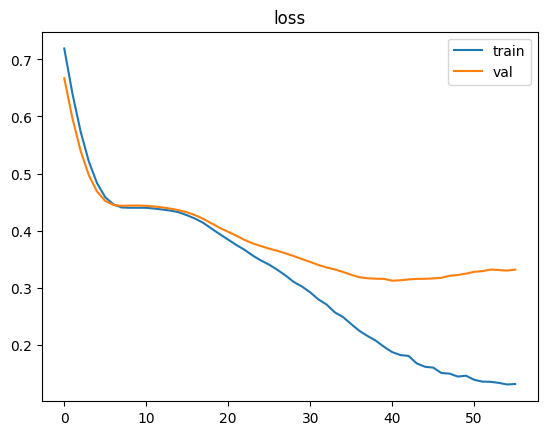

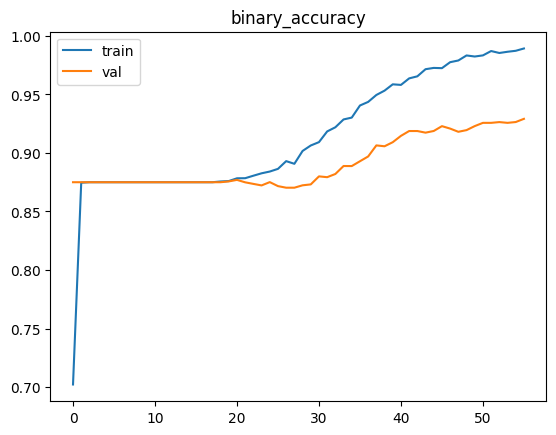

In [119]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [120]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.19697272913022476
train_binary_accuracy: 0.9606206254525618
loss: 0.2719185243953358
binary_accuracy: 0.9310064966028387


In [99]:
model.state_dict().keys()

odict_keys(['unmixing_layer.weight', 'unmixing_layer.bias', 'temp_conv.weight', 'temp_conv.bias', 'timesel_list.0.0.weight', 'timesel_list.0.0.bias', 'timesel_list.1.0.weight', 'timesel_list.1.0.bias', 'timesel_list.2.0.weight', 'timesel_list.2.0.bias', 'timesel_list.3.0.weight', 'timesel_list.3.0.bias', 'timesel_list.4.0.weight', 'timesel_list.4.0.bias', 'timesel_list.5.0.weight', 'timesel_list.5.0.bias', 'timesel_list.6.0.weight', 'timesel_list.6.0.bias', 'timesel_list.7.0.weight', 'timesel_list.7.0.bias', 'comp_conv.weight', 'comp_conv.bias', 'fc_layer.weight', 'fc_layer.bias'])

In [131]:
x, y = next(iter(DataLoader(test, len(test))))
x = model.unmixing_layer(x)
x = model.temp_conv(x)
x_est = torch.stack(
    [
        timesel(x[:, i, :]) for i, timesel in enumerate(model.timesel_list)
    ],
    1
)
x_weighted = torch.zeros_like(x)
for i, window in enumerate(model.windows):
    x_weighted[:, :, window] = x[:, :, window] * x_est[:, :, i]

x = model.comp_conv(x_weighted)

In [125]:
x_weighted.shape

torch.Size([282, 8, 602])

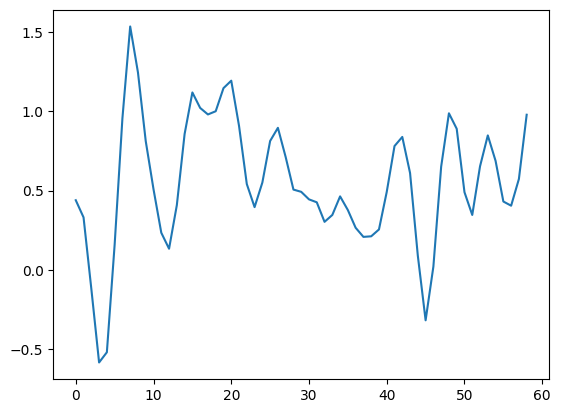

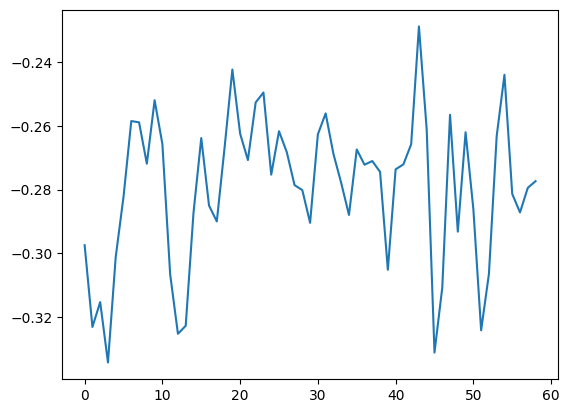

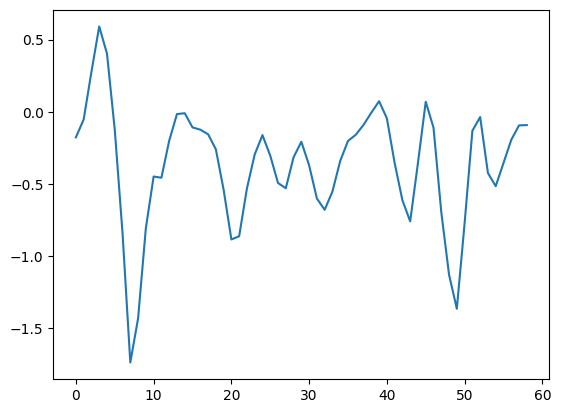

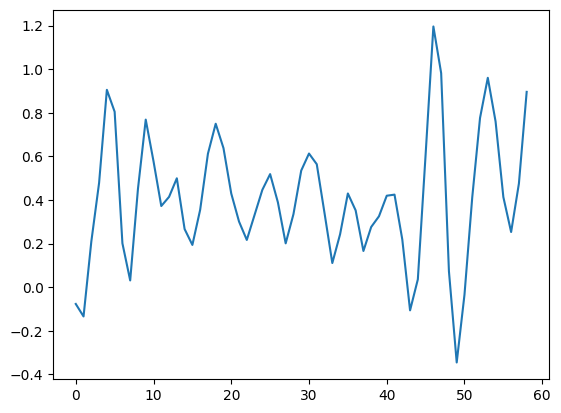

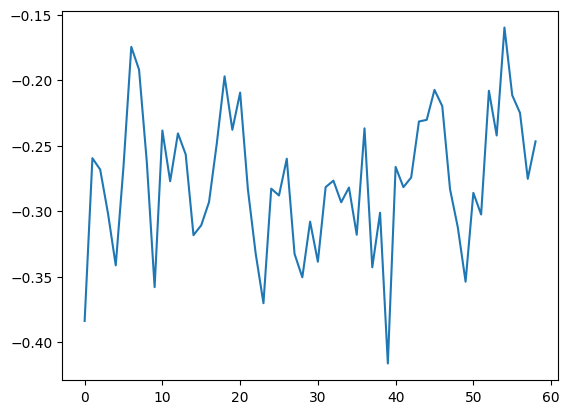

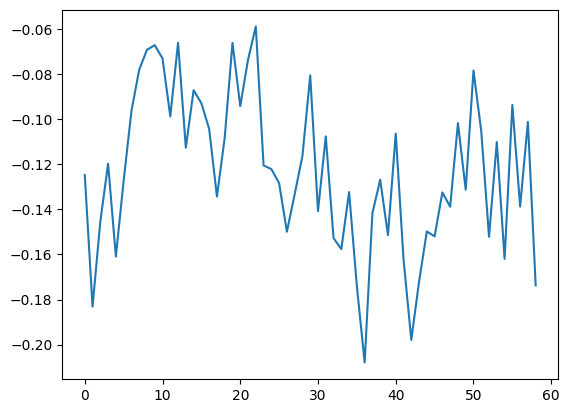

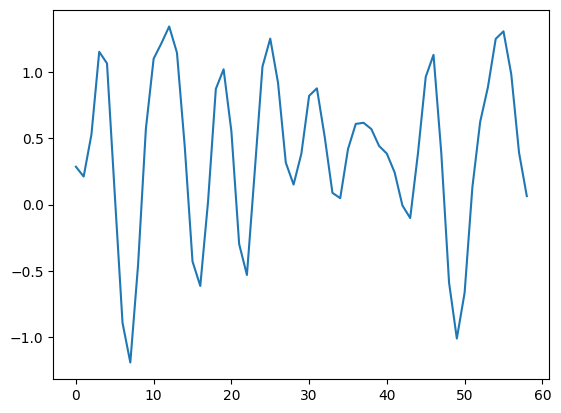

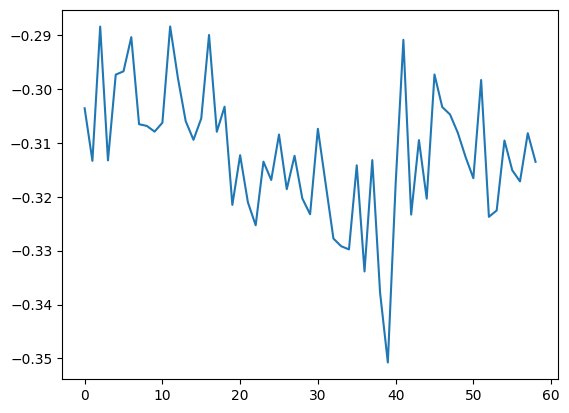

In [133]:
for i, branch_est in enumerate(x_weighted.detach().numpy().mean(0)):
    plt.plot(x.detach().numpy().mean(0)[i])
    # plt.plot(branch_est)
    plt.show()